# **Analyzing Stock Performance and Building a Dashboard**

## 1. Import Libraries

In [52]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Web scraping and data acquisition
import requests
from bs4 import BeautifulSoup
from io import StringIO
from alpha_vantage.timeseries import TimeSeries

## 2. Data Acquisition Functions

In [30]:
def fetch_stock_data(ticker_symbol, interval=None, outputsize="full"):
    """
    Fetch historical stock data from Alpha Vantage.
    
    Parameters:
    ticker_symbol (str): Stock ticker symbol (e.g., "AAPL")
    interval (str): "daily", "weekly", "monthly"
    outputsize (str): "compact" (100 rows) or "full"
    
    Returns:
    pandas.DataFrame: Stock data with Date and Close price columns
    """
    API_KEY = "LWX7AYVW5RZQNAII"  
    ts = TimeSeries(key=API_KEY, output_format='pandas')

    if interval == "daily":
        data, _ = ts.get_daily(symbol=ticker_symbol, outputsize=outputsize)
    elif interval == "weekly":
        data, _ = ts.get_weekly(symbol=ticker_symbol)
    elif interval == "monthly":
        data, _ = ts.get_monthly(symbol=ticker_symbol)
    else:
        raise ValueError("interval must be: daily, weekly o monthly")

    data.reset_index(inplace=True)
    data.rename(columns={'date': 'Date', '4. close': 'Close'}, inplace=True)

    return data[['Date', 'Close']]
    

def fetch_revenue_data(url, headers):
    """
    Scrape revenue data from Macrotrends website.
    
    Parameters:
    url (str): URL of the revenue data page
    headers (dict): HTTP headers for the request
    
    Returns:
    pandas.DataFrame: Revenue data with Date and Revenue columns
    """
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise exception for HTTP errors
        
        html_content = StringIO(response.text)
        tables = pd.read_html(html_content)
        
        if len(tables) < 2:
            print("Revenue table not found on the page")
            return None
            
        revenue_data = tables[1]
        revenue_data.columns = ["Date", "Revenue"]
        
        # Clean and transform revenue data
        revenue_data["Date"] = pd.to_datetime(revenue_data["Date"])
        revenue_data["Revenue"] = (
            revenue_data["Revenue"]
            .str.replace("$", "", regex=False)
            .str.replace(",", "", regex=False)
            .astype(np.float64)
        )
        
        return revenue_data
    except Exception as e:
        print(f"Error fetching revenue data: {e}")
        return None

## 3. Visualization Function

In [33]:
def create_stock_revenue_plot(stock_data, revenue_data, title):
    """
    Create a professional interactive visualization of stock price and revenue trends.
    
    Parameters:
    stock_data (pandas.DataFrame): Stock data with Date and Close columns
    revenue_data (pandas.DataFrame): Revenue data with Date and Revenue columns
    title (str): Title for the visualization
    
    Returns:
    plotly.graph_objects.Figure: Interactive plot figure
    """
    # Create subplots: 2 rows (Price + Revenue), shared x-axis
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        subplot_titles=("Historical Share Price", "Historical Revenue"),
        vertical_spacing=0.12
    )

    # --- Stock Price Trace ---
    fig.add_trace(
        go.Scatter(
            x=pd.to_datetime(stock_data["Date"]),
            y=stock_data["Close"].astype(float),
            showlegend=False,
            line=dict(color="#1f77b4", width=2),
            hovertemplate="Date: %{x}<br>Price: $%{y:.2f}<extra></extra>"
        ),
        row=1, col=1
    )

    # --- Revenue Trace ---
    fig.add_trace(
        go.Scatter(
            x=pd.to_datetime(revenue_data["Date"]),
            y=revenue_data["Revenue"].astype(float),
            showlegend=False,
            line=dict(color="#ff7f0e", width=2),
            hovertemplate="Date: %{x}<br>Revenue: $%{y:.0f}M<extra></extra>"
        ),
        row=2, col=1
    )

    # --- Axes ---
    fig.update_yaxes(title_text="Price (USD)", row=1, col=1, showgrid=True, zeroline=False)
    fig.update_yaxes(title_text="Revenue (USD Millions)", row=2, col=1, showgrid=True, zeroline=False)
    fig.update_xaxes(title_text="Date", row=2, col=1)

    # --- Layout---
    fig.update_layout(
        title=dict(text=title, x=0.5, xanchor="center", font=dict(size=20)),
        template="plotly_white",
        height=800,
        hovermode="x unified",
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
        margin=dict(l=60, r=40, t=80, b=50),
        xaxis2=dict(rangeslider=dict(visible=True), type="date"),  # rangeslider only once (bottom)
    )

    return fig

## 4. Data Collection and Processing 

In [38]:
# Set user agent for web scraping
request_headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# Define the start date
start_date = "2010-01-01"

# Tesla data
tesla_stock_data = fetch_stock_data("TSLA", interval="monthly", outputsize="full")
tesla_stock_data = tesla_stock_data[pd.to_datetime(tesla_stock_data['Date']) >= start_date]
tesla_revenue_url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
tesla_revenue_data = fetch_revenue_data(tesla_revenue_url, request_headers)
tesla_revenue_data = tesla_revenue_data[pd.to_datetime(tesla_revenue_data['Date']) >= start_date]

# NVIDIA data
nvda_stock_data = fetch_stock_data("NVDA", interval="monthly", outputsize="full")
nvda_stock_data = nvda_stock_data[pd.to_datetime(nvda_stock_data['Date']) >= start_date]
nvda_revenue_url = "https://www.macrotrends.net/stocks/charts/NVDA/nvidia/revenue"
nvda_revenue_data = fetch_revenue_data(nvda_revenue_url, request_headers)
nvda_revenue_data = nvda_revenue_data[pd.to_datetime(nvda_revenue_data['Date']) >= start_date]

## 5. Data Validation 

In [41]:
# Check if data was successfully retrieved
if tesla_stock_data is not None and tesla_revenue_data is not None:
    print("Tesla data successfully retrieved:")
    print(f"Stock data points: {len(tesla_stock_data)}")
    print(f"Revenue data points: {len(tesla_revenue_data)}")
    print(f"Date range - Stock: {tesla_stock_data.Date.min()} to {tesla_stock_data.Date.max()}")
    print(f"Date range - Revenue: {tesla_revenue_data.Date.min()} to {tesla_revenue_data.Date.max()}")
else:
    print("Failed to retrieve Tesla data")

if nvda_stock_data is not None and nvda_revenue_data is not None:
    print("\nNVIDIA data successfully retrieved:")
    print(f"Stock data points: {len(nvda_stock_data)}")
    print(f"Revenue data points: {len(nvda_revenue_data)}")
    print(f"Date range - Stock: {nvda_stock_data.Date.min()} to {nvda_stock_data.Date.max()}")
    print(f"Date range - Revenue: {nvda_revenue_data.Date.min()} to {nvda_revenue_data.Date.max()}")
else:
    print("Failed to retrieve NVIDIA data")

Tesla data successfully retrieved:
Stock data points: 182
Revenue data points: 62
Date range - Stock: 2010-07-30 00:00:00 to 2025-08-19 00:00:00
Date range - Revenue: 2010-03-31 00:00:00 to 2025-06-30 00:00:00

NVIDIA data successfully retrieved:
Stock data points: 188
Revenue data points: 62
Date range - Stock: 2010-01-29 00:00:00 to 2025-08-19 00:00:00
Date range - Revenue: 2010-01-31 00:00:00 to 2025-04-30 00:00:00


## 6. Visualization

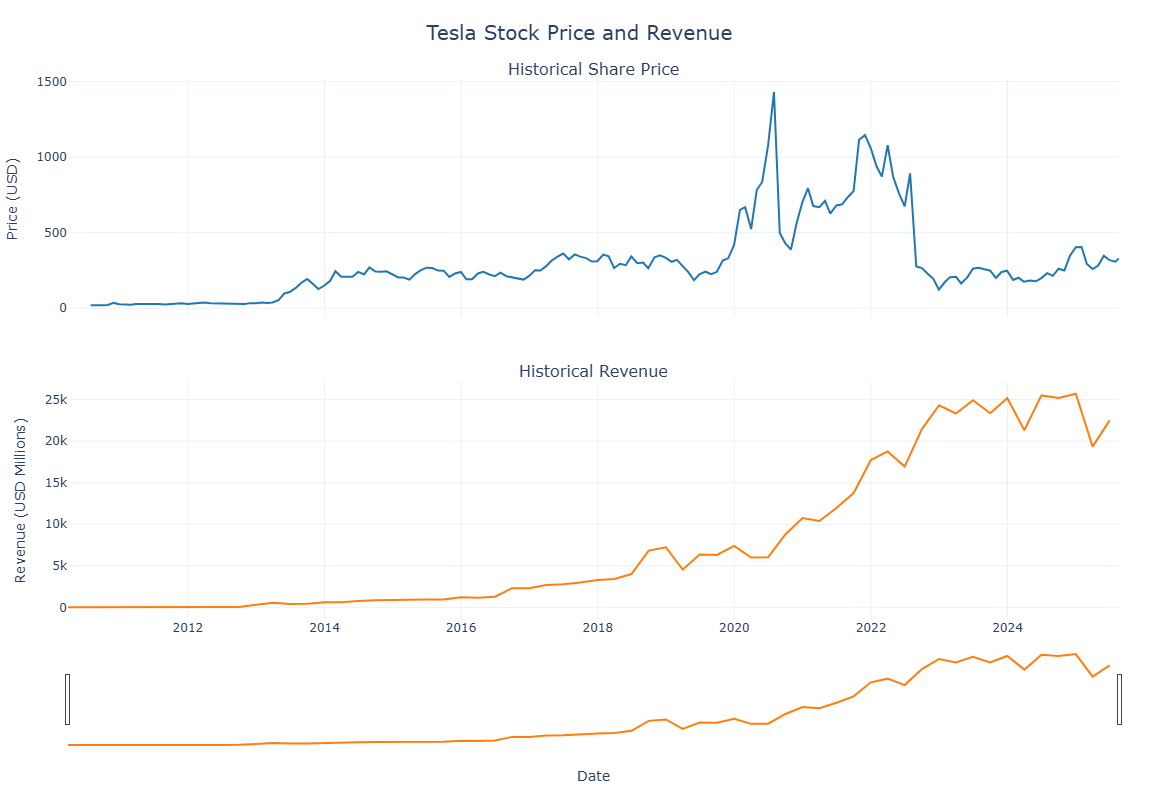

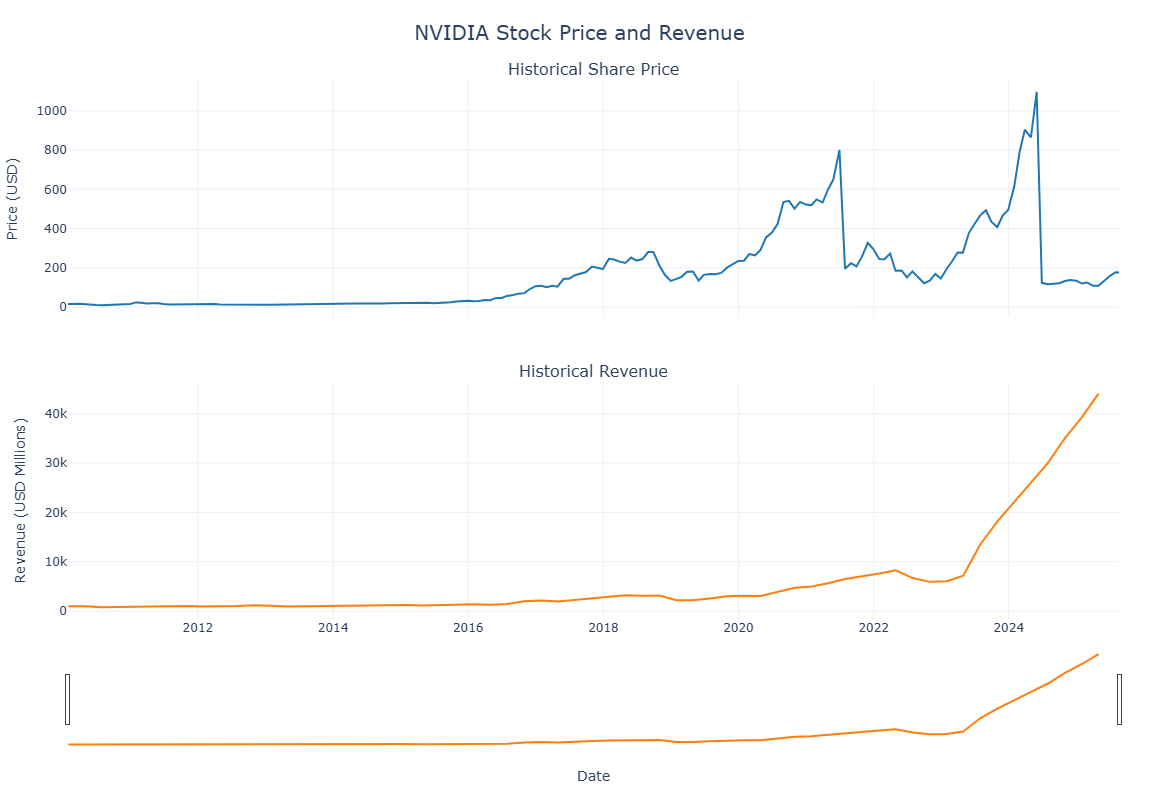

In [56]:
# Generate and display visualizations
if tesla_stock_data is not None and tesla_revenue_data is not None:
    tesla_fig = create_stock_revenue_plot(tesla_stock_data, tesla_revenue_data, "Tesla Stock Price and Revenue")
    tesla_fig.show()
else:
    print("Cannot create Tesla visualization due to missing data")

if nvda_stock_data is not None and nvda_revenue_data is not None:
    nvda_fig = create_stock_revenue_plot(nvda_stock_data, nvda_revenue_data, "NVIDIA Stock Price and Revenue")
    nvda_fig.show()
else:
    print("Cannot create GameStop visualization due to missing data")

pio.write_html(tesla_fig, file='tesla_dashboard.html', auto_open=True)
pio.write_html(nvda_fig, file='NVIDIA_dashboard.html', auto_open=True)

## 7. Correlation Analysis

Tesla Stock Price-Revenue Correlation: 0.428


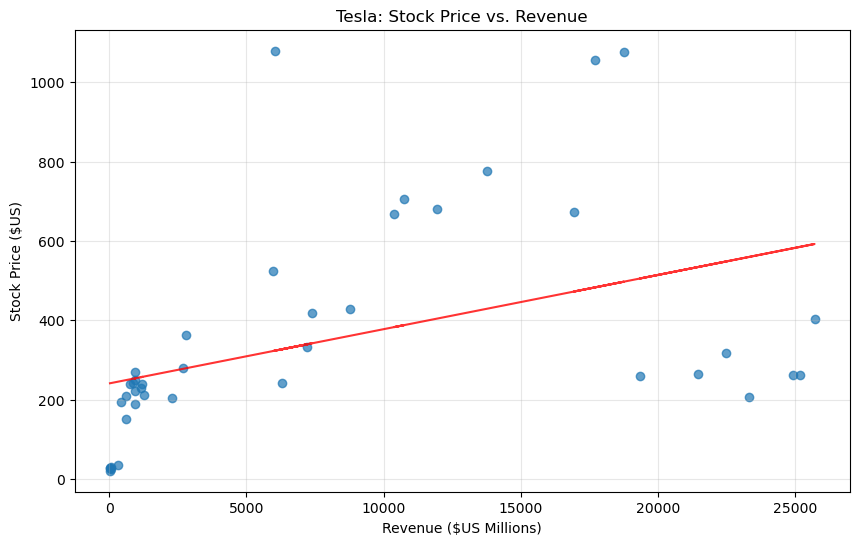

NVIDIA Stock Price-Revenue Correlation: 0.346


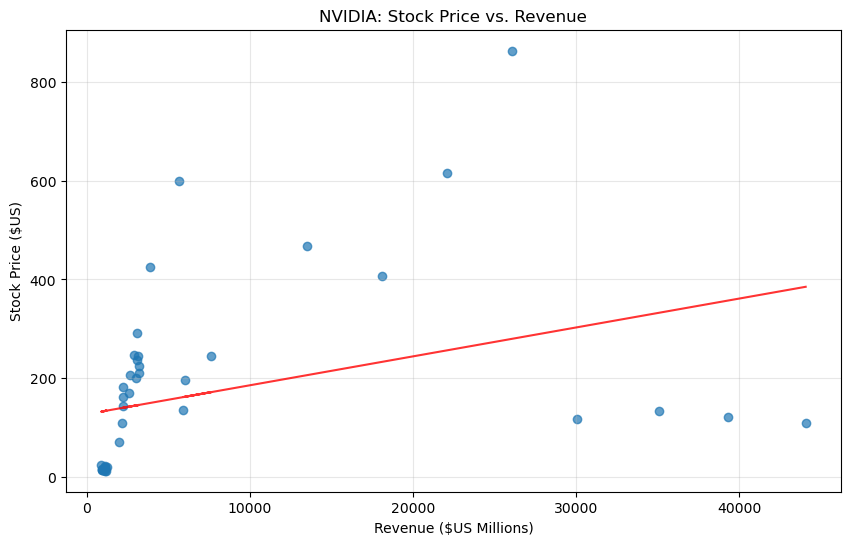

In [65]:
def calculate_correlation(stock_data, revenue_data, company_name):
    """
    Calculate and display correlation between stock price and revenue.
    
    Parameters:
    stock_data (pandas.DataFrame): Stock data with Date and Close columns
    revenue_data (pandas.DataFrame): Revenue data with Date and Revenue columns
    company_name (str): Name of the company for display purposes
    """
    # Merge datasets on date
    merged_data = pd.merge(
        stock_data, 
        revenue_data, 
        on="Date", 
        how="inner"
    )
    
    if len(merged_data) > 1:  # Need at least 2 points for correlation
        correlation = merged_data["Close"].corr(merged_data["Revenue"])
        print(f"{company_name} Stock Price-Revenue Correlation: {correlation:.3f}")
        
        # Create a scatter plot to visualize the relationship
        plt.figure(figsize=(10, 6))
        plt.scatter(merged_data["Revenue"], merged_data["Close"], alpha=0.7)
        plt.xlabel("Revenue ($US Millions)")
        plt.ylabel("Stock Price ($US)")
        plt.title(f"{company_name}: Stock Price vs. Revenue")
        
        # Add trend line
        z = np.polyfit(merged_data["Revenue"], merged_data["Close"], 1)
        p = np.poly1d(z)
        plt.plot(merged_data["Revenue"], p(merged_data["Revenue"]), "r", alpha=0.8)
        
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"Insufficient data to calculate correlation for {company_name}")

# Calculate correlations
if tesla_stock_data is not None and tesla_revenue_data is not None:
    calculate_correlation(tesla_stock_data, tesla_revenue_data, "Tesla")

if nvda_stock_data is not None and nvda_revenue_data is not None:
    calculate_correlation(nvda_stock_data, nvda_revenue_data, "NVIDIA")

The correlation analysis reveals interesting relationships between stock price and revenue performance:

- **Tesla (0.428)**: Shows a moderate positive correlation, suggesting that revenue growth tends to coincide with stock price increases, though other factors clearly play significant roles in Tesla's valuation.

- **NVIDIA (0.346)**: Demonstrates a weaker but still positive correlation, indicating that while revenue performance influences stock price, NVIDIA's valuation is likely driven substantially by other factors such as market expectations about AI growth, semiconductor industry cycles, and future technology trends.

These correlation coefficients suggest that both companies' stock prices respond to revenue performance but are also significantly influenced by market sentiment, future growth expectations, and industry-specific factors beyond current financial results.

*Note: Correlation values range from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no linear relationship.*